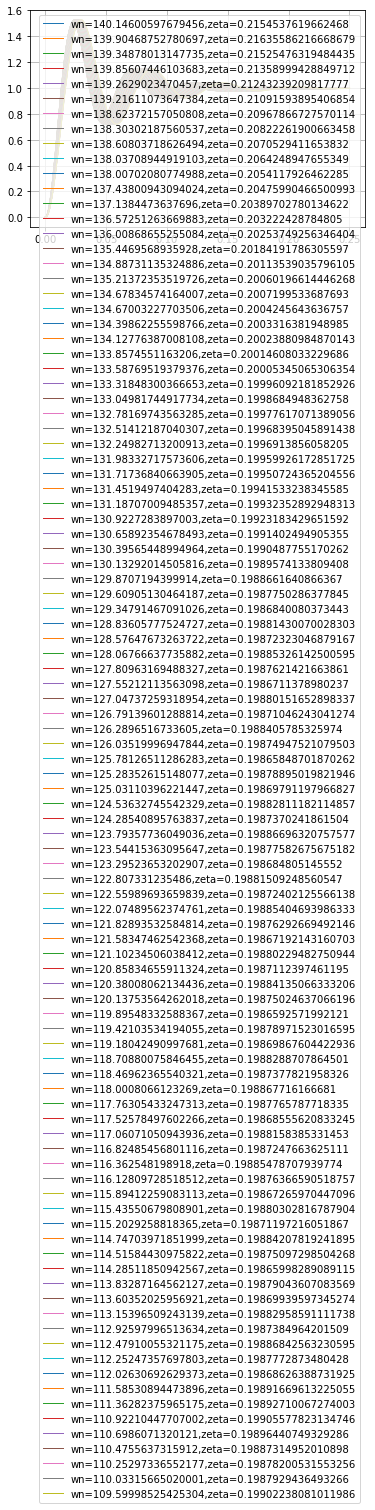

In [6]:
import control
from control.matlab import *
import numpy as np
import sympy as sp
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1
%matplotlib inline

def stepinfo(sys, t=None, SettlingTimeThreshold=0.02, RiseTimeLimits=[0.1,0.9]):
#     sys = control.timeresp._get_ss_simo(sys)
    
    t, step_out = control.step_response(sys, t)
    step_out = step_out.flatten()
        
    # Steady state value
    InfValue = step_out[-1]
    
    # RiseTime
    tr_lower_index = (np.where(step_out >= RiseTimeLimits[0] * InfValue)[0])[0]
    tr_upper_index = (np.where(step_out >= RiseTimeLimits[1] * InfValue)[0])[0]
    RiseTime = t[tr_upper_index] - t[tr_lower_index]

    # SettlingTime
    sup_margin = (1. + SettlingTimeThreshold) * InfValue
    inf_margin = (1. - SettlingTimeThreshold) * InfValue
    SettlingTime = 0
    for i in reversed(range(t.size)):
        if (step_out[i] <= inf_margin) | (step_out[i] >= sup_margin):
            if t.size > i + 1:
                i += 1
            SettlingTime = t[i]
            break
    
    # Peak
    PeakIndex = np.abs(step_out).argmax()
    PeakValue = step_out[PeakIndex]
    PeakTime = t[PeakIndex]
    SettlingMax = (step_out).max()
    SettlingMin = (step_out[tr_upper_index:]).min()
    UnderShoot = step_out.min()
    OverShoot = 100. * (step_out.max() -InfValue) / (InfValue -step_out[0])
    
    S = {
        'RiseTime': RiseTime,
        'SettlingTime': SettlingTime,
        'SettlingMin': SettlingMin,
        'SettlingMax': SettlingMax,
        'Overshoot': OverShoot,
        'Undershoot': UnderShoot,
        'Peak': PeakValue,
        'PeakTime': PeakTime,
        'SteadyStateValue': InfValue
    }

    return S

def FOM(S: dict, SettlingTimeThreshold=0.05):
    # calcula o zeta necessário usando Mp
    zeta = -np.log(S['Overshoot'] / 100.) / np.sqrt( np.pi**2 + np.log(S['Overshoot'] / 100.)**2 )
    
    # calcula o wn necessário usando zeta
    try:
        wn = np.pi / (S['PeakTime'] * np.sqrt(1 - zeta**2) )
    except:
        wn = - np.log(SettlingTimeThreshold * np.sqrt(1 - zeta**2)) / (S['SettlingTime'] * zeta)
    Fn = wn * 2 * np.pi
    wd = wn * np.sqrt(1 - zeta**2)
    Fd = wd * 2 * np.pi
    
    tp = np.pi / wd
    Mp = np.exp(-np.pi * zeta / np.sqrt(1 - zeta**2))
    
    tr = ((np.pi / 2) + np.arcsin(zeta)) / (wn * np.sqrt(1 -zeta**2))
    
    fom = {
        'zeta': zeta,
        'wn': wn,
        'Fn': Fn,
        'wd': wd,
        'Fd': Fd,
        'tp': tp,
        'Mp': Mp,
        'tr': tr
    }
    return fom


def test(S: dict, SettlingTimeThreshold=0.05, show=False, plot=True):
    fom = FOM(S, SettlingTimeThreshold)
    G = tf([fom['wn']**2], [1, 2*fom['zeta'] * fom['wn'], fom['wn']**2])
    
    if show:
        print(f'S: {json.dumps(S, indent=4)}')
        print(f'fom: {json.dumps(fom, indent=4)}')
        print(f'G: {G}')

    if plot:
        final_time = 2 * S['SettlingTime']
        points = 1E3
        sampling = final_time / points
        T = np.arange(final_time / sampling) * sampling
        yout, T = step(G, T)
        plt.plot(T, yout, label=f"wn={fom['wn']},zeta={fom['zeta']}")
        plt.legend()
        plt.grid()
        

    return stepinfo(G, T, SettlingTimeThreshold=SettlingTimeThreshold)

###########################################################################
###########################################################################
###########################################################################
###########################################################################
###########################################################################
###########################################################################
###########################################################################

imax = 100
S = [0] * imax

S[0] = {
    'Overshoot': 50,
    'SettlingTime': 0.1,
}

i = 0
while i < imax -1:
    S[i+1] = test(S[i])
    i += 1